# GPyTorch Regression Tutorial

## Introduction

In this notebook, we demonstrate many of the design features of GPyTorch using the simplest example, training an RBF kernel Gaussian process on a simple function. We'll be modeling the function

\begin{align}
y &= \sin(2\pi x) + \epsilon \\
  \epsilon &\sim \mathcal{N}(0, 0.04) 
\end{align}

with 100 training examples, and testing on 51 test examples.

**Note:** this notebook is not necessarily intended to teach the mathematical background of Gaussian processes, but rather how to train a simple one and make predictions in GPyTorch. For a mathematical treatment, Chapter 2 of Gaussian Processes for Machine Learning provides a very thorough introduction to GP regression (this entire text is highly recommended): http://www.gaussianprocess.org/gpml/chapters/RW2.pdf

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up training data

In the next cell, we set up the training data for this example. We'll be using 100 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels.

In [2]:
# Training data is 100 points in [0,1] inclusive regularly spaced
def f(x, noise=1e-1):
    #y = torch.sin(x * (2 * math.pi))
    y = torch.sin(x * (2 * math.pi)) ** 3
    y = y + torch.randn_like(y) * noise
    return y

train_x = torch.linspace(-1, 1, 1000)
train_y = f(train_x)

def f(x, noise=1e-1):
    # Styblinski-Tang
    y = (x.pow(2) - 16*x.pow(2) + 5*x).sum(-1) / 2
    y = y + torch.randn_like(y) * noise
    return y

train_x = torch.randn(1000, 10)
train_y = f(train_x)

In [3]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        
        #assert 1 <= train_x.ndim <= 2
        #init_theta = (train_x[1:] - train_x[:-1]).norm(2, dim=-1).median()
        #self.covar_module = gpytorch.kernels.ScaleKernel(
        #                        gpytorch.kernels.RBFKernel().initialize(lengthscale=init_theta)
        #)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [4]:
model = model.cuda()
train_x = train_x.cuda()
train_y = train_y.cuda()

In [5]:
model = model.float()
train_x = train_x.float()
train_y = train_y.float()

### Model modes

Like most PyTorch modules, the `ExactGP` has a `.train()` and `.eval()` mode.
- `.train()` mode is for optimizing model hyperameters.
- `.eval()` mode is for computing predictions through the model posterior.

## Training the model

In the next cell, we handle using Type-II MLE to train the hyperparameters of the Gaussian process.

The most obvious difference here compared to many other GP implementations is that, as in standard PyTorch, the core training loop is written by the user. In GPyTorch, we make use of the standard PyTorch optimizers as from `torch.optim`, and all trainable parameters of the model should be of type `torch.nn.Parameter`. Because GP models directly extend `torch.nn.Module`, calls to methods like `model.parameters()` or `model.named_parameters()` function as you might expect coming from PyTorch.

In most cases, the boilerplate code below will work well. It has the same basic components as the standard PyTorch training loop:

1. Zero all parameter gradients
2. Call the model and compute the loss
3. Call backward on the loss to fill in gradients
4. Take a step on the optimizer

However, defining custom training loops allows for greater flexibility. For example, it is easy to save the parameters at each step of training, or use different learning rates for different parameters (which may be useful in deep kernel learning for example).

In [6]:
training_iter = 100


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

with gpytorch.settings.skip_logdet_forward(), \
    gpytorch.settings.max_preconditioner_size(0), \
    gpytorch.settings.cg_tolerance(1e-1), \
    gpytorch.settings.ir_solve(), \
    gpytorch.settings.max_cg_iterations(len(train_y)), \
    gpytorch.settings.deterministic_probes(), \
    gpytorch.settings.num_trace_samples(10)\
:
    
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()

/mnt/storage1/Documents/repos/gpytorch/gpytorch/functions/_inv_quad_log_det.py:75: UserWarning: Deterministic probes will currently work only if you aren't training multiple independent models simultaneously.
  warnings.warn(


Tolerance after 5 iterations: 0.03808796405792236
Iter 1/100 - Loss: 1.061   lengthscale: 0.693   noise: 0.693
Tolerance after 3 iterations: 0.2469482421875
Iter 2/100 - Loss: 1.058   lengthscale: 0.644   noise: 0.644
Tolerance after 6 iterations: 0.162841796875
Iter 3/100 - Loss: 1.032   lengthscale: 0.599   noise: 0.598
Tolerance after 3 iterations: 0.30078125
Iter 4/100 - Loss: 1.028   lengthscale: 0.555   noise: 0.554
Tolerance after 8 iterations: 0.059722900390625
Iter 5/100 - Loss: 0.992   lengthscale: 0.515   noise: 0.513
Tolerance after 2 iterations: 0.314208984375
Iter 6/100 - Loss: 0.989   lengthscale: 0.477   noise: 0.474
Tolerance after 7 iterations: 0.2174072265625
Iter 7/100 - Loss: 0.970   lengthscale: 0.441   noise: 0.437
Tolerance after 9 iterations: 0.12371826171875
Iter 8/100 - Loss: 0.977   lengthscale: 0.410   noise: 0.402
Tolerance after 1 iterations: 0.285888671875
Iter 9/100 - Loss: 0.976   lengthscale: 0.384   noise: 0.369
Tolerance after 11 iterations: 0.09722

In [7]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    #test_x = torch.linspace(0, 1, 10, device=train_x.device)
    test_x = torch.linspace(-2, 2, 100, device=train_x.device)
    observed_pred = likelihood(model(test_x))

Tolerance after 32 iterations: 0.005646240431815386


In [8]:
(observed_pred.mean - f(test_x)).pow(2).mean()

tensor(0.1617, device='cuda:0')

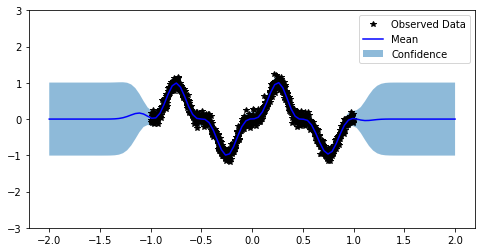

In [9]:
with torch.no_grad():
    # Initialize plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.cpu().numpy(), observed_pred.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])